# Task 1 - Analyze the dataset
Parse the groundtruth information into a dictionary. The key will be the name of the picture and the value a list of the signals and their information. 

This data structure let us find directly the picture that we want to process.

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

%matplotlib inline

import numpy as np
import os, sys
import imageio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Relative paths
path_txt = os.path.join('dataset', 'train', 'gt')
path_mask = os.path.join('dataset', 'train', 'mask')
dirs_txt = os.listdir(path_txt)
dirs_mask = os.listdir(path_mask)

data = dict()

for gt in dirs_txt:
    with open(os.path.join(path_txt, gt)) as f:
        lines = f.readlines()
        
        im_name = gt.replace('gt', 'mask').replace('txt', 'png')
        im_open = (imageio.imread(os.path.join(path_mask, im_name)))

        lista = list()
        
        # Extract grountruth information
        for l in lines:
            tly, tlx, bry, brx, tipo = l.split(' ')  
            tly, tlx, bry, brx = map(float, [tly, tlx, bry, brx])
            d = dict()
            d['type'] = tipo.strip()
            
            w = brx - tlx
            h = bry - tly
            
            d['width'] = w
            d['height'] = h
            d['bbox_area'] = w*h
            d['form_factor'] = w/h
            
            d['tly'] = round(tly)
            d['tlx'] = round(tlx)
            d['bry'] = round(bry)
            d['brx'] = round(brx)
            
            sub_mask = im_open[d['tly']:d['bry'], d['tlx']:d['brx']]
            mask_area = np.count_nonzero(sub_mask)
            d['mask_area'] = mask_area
            d['filling_ratio'] = mask_area / d['bbox_area']
            
            lista.append(d)
            
        data[gt] = lista
    

Show information in pandas format to filter the signals by type easily.


In [2]:
columns = ['type','width','height','form_factor','bbox_area','mask_area','filling_ratio']
df = pd.DataFrame.from_dict({(i,n): data[i][n]
                        for i in data.keys()
                        for n,v in enumerate(data[i])}, columns=columns, orient='index').sort_values(['type'])
df

,,type,width,height,form_factor,bbox_area,mask_area,filling_ratio
gt.01.001555.txt,0,A,79.70,72.51,1.099159,5779.0470,2905,0.502678
gt.01.001777.txt,0,A,86.73,79.25,1.094385,6873.3525,3438,0.500193
gt.01.001784.txt,0,A,140.81,125.71,1.120118,17701.2251,8927,0.504315
gt.01.001785.txt,0,A,184.71,165.30,1.117423,30532.5630,15232,0.498877
gt.01.001787.txt,0,A,104.12,103.53,1.005699,10779.5436,5419,0.502711
gt.01.001788.txt,0,A,87.64,85.89,1.020375,7527.3996,3752,0.498446
gt.01.001789.txt,0,A,130.59,131.18,0.995502,17130.7962,8612,0.502720
gt.01.001796.txt,0,A,80.73,77.05,1.047761,6220.2465,3134,0.503839
gt.01.001797.txt,0,A,68.55,64.30,1.066096,4407.7650,2186,0.495943
gt.01.001798.txt,0,A,62.20,58.10,1.070568,3613.8200,1804,0.499195


Maximum values
       width  height  form_factor   bbox_area  mask_area  filling_ratio
type                                                                   
A     205.89  179.91     1.227632  37041.6699      18502       0.524561
B     123.23  149.01     1.185969  18362.5023       9164       0.499061
C     235.30  237.65     1.068369  55919.0450      43770       0.786658
D     201.47  183.83     1.095958  37036.2301      31318       0.845604
E     218.90  215.86     1.067998  47251.7540      37035       0.784436
F     273.53  220.53     1.419829  52695.5545      52608       1.008235


Minimum values
      width  height  form_factor  bbox_area  mask_area  filling_ratio
type                                                                 
A     30.14   29.75     0.745039   909.7550        457       0.490679
B     52.52   44.96     0.750674  2361.2992       1157       0.489210
C     35.69   36.80     0.644526  1374.4800       1077       0.777067
D     29.46   30.96     0.648589   912.081

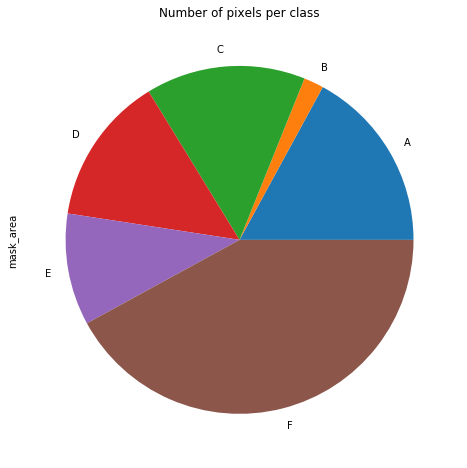

In [3]:
# Calculate some statistics
print("Maximum values")
type_counts = df.groupby('type').aggregate(max)
print(type_counts)

type_counts = df.groupby('type').aggregate(min)
print("\n\nMinimum values")
print(type_counts)

print("\n\nSummatory")
type_counts = df.drop(columns=['form_factor','filling_ratio']).groupby('type').aggregate(sum)
print(type_counts)

# Pie chart
type_counts['mask_area'].plot(figsize=(12, 8),kind='pie',sort_columns=True, title="Number of pixels per class")
normalized_df=type_counts['mask_area']/type_counts['mask_area'].sum()*100

print("\n\nPercentage of pixels per class")
print(normalized_df)

Plot the main color of each class (Purple means red and blue) to see the balance between them.

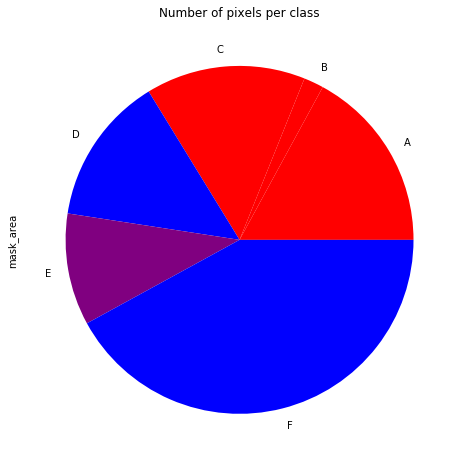

In [4]:
cmap = mpl.colors.ListedColormap(['red','red','red', 'blue', 'purple', 'blue'])
type_counts['mask_area'].plot(figsize=(12, 8),kind='pie',sort_columns=True, colormap=cmap, title="Number of pixels per class")


### Conclusions: 
Large range of sizes: 
- From 900 pixels (about 30x30) to 56000 of area


Total number of pixels of each class is very different:
- class F: 42%
- class B: 2%

Average values
      width  height  form_factor  bbox_area  mask_area  filling_ratio
type                                                                 
A     92.27   86.62         1.06    9529.07    4772.44           0.50
B     83.71   85.01         1.02    7711.40    3811.79           0.49
C     96.42  100.35         0.95   11615.66    9094.53           0.78
D     76.97   78.62         0.97    7135.12    5609.65           0.78
E     88.98   96.20         0.94   10069.54    7881.18           0.78
F     85.63  103.52         0.83   10177.02   10092.66           0.99


Standard deviation values
       width  height  form_factor  bbox_area  mask_area  filling_ratio
type                                                                  
A     41.336  38.008        0.073   8279.863   4143.273          0.005
B     23.771  30.346        0.148   4742.369   2355.826          0.003
C     46.248  43.710        0.108  11043.924   8649.408          0.002
D     34.466  32.731        0.085   6220.3

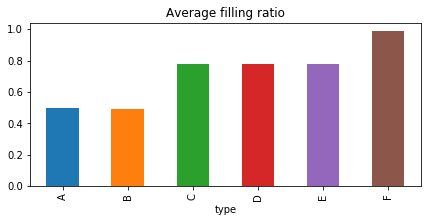

In [35]:
# Study average, std and median values
type_counts = df.groupby('type').aggregate(np.average).round(2)
print("Average values")
print(type_counts)
#type_counts.drop(columns=['width','height','form_factor']).plot(figsize=(5, 8),kind='bar',sort_columns=True,subplots=True)
type_counts['filling_ratio'].plot(figsize=(7, 3),kind='bar',sort_columns=True, title="Average filling ratio")

type_counts = df.groupby('type').aggregate(np.std).round(3)
print("\n\nStandard deviation values")
print(type_counts)

type_counts = df.groupby('type').aggregate(np.median).round(2)
print("\n\nMedian values")
print(type_counts)

### Conclusions:
Average and median bounding-box sizes around 90 pixels

Filling_ratio pretty consistent through classes
- Triangles: 0.5
- Circles: 0.77
- Rectangles: 0.99

# Task 2 - Split training dataset

Extract the 30% of the training images of each class to set up a validation dataset

A    103
B     14
C     47
D     71
E     38
F    120
Name: type, dtype: int64


Number of signals: 393


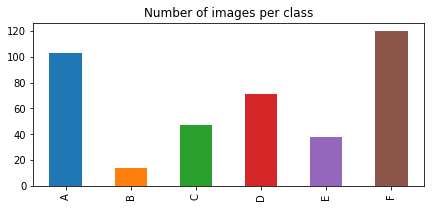

In [30]:
# Count number of signals per class
n_signals = df['type'].value_counts(sort=False).reindex(['A','B','C','D','E','F'])
print(n_signals)
n_signals = df['type'].value_counts(sort=False).reindex(['A','B','C','D','E','F']).aggregate(sum)
print("\n\nNumber of signals: {}".format(n_signals))

# Plot
df['type'].value_counts(sort=False).reindex(['A','B','C','D','E','F']).plot(figsize=(7, 3),kind='bar',sort_columns=True, title="Number of images per class")


In [7]:
# Get only one class
df_filtered = df[df['type'] == "B"]
df_filtered

,,type,width,height,form_factor,bbox_area,mask_area,filling_ratio
gt.01.001223.txt,0,B,57.14,48.18,1.185969,2753.0052,1372,0.498364
gt.01.001222.txt,0,B,52.52,44.96,1.168149,2361.2992,1157,0.489984
gt.01.003462.txt,0,B,106.70,96.34,1.107536,10279.4780,5093,0.495453
gt.00.001768.txt,0,B,80.61,87.42,0.922100,7046.9262,3482,0.494116
gt.00.001766.txt,0,B,120.82,121.22,0.996700,14645.8004,7220,0.492974
gt.00.004563.txt,0,B,64.70,62.74,1.031240,4059.2780,2009,0.494916
gt.00.004564.txt,0,B,62.26,57.36,1.085425,3571.2336,1767,0.494787
gt.00.004565.txt,0,B,70.10,68.38,1.025154,4793.4380,2345,0.489210
gt.00.000978.txt,0,B,90.09,78.75,1.144000,7094.5875,3505,0.494039
gt.00.000977.txt,0,B,69.94,62.47,1.119577,4369.1518,2156,0.493460


In [8]:
df_sorted_train = df_filtered.sample(frac=0.7)
df_sorted_train

,,type,width,height,form_factor,bbox_area,mask_area,filling_ratio
gt.00.000978.txt,0,B,90.09,78.75,1.144000,7094.5875,3505,0.494039
gt.00.000977.txt,0,B,69.94,62.47,1.119577,4369.1518,2156,0.493460
gt.00.001526.txt,0,B,123.23,149.01,0.826991,18362.5023,9164,0.499061
gt.00.001766.txt,0,B,120.82,121.22,0.996700,14645.8004,7220,0.492974
gt.00.004565.txt,0,B,70.10,68.38,1.025154,4793.4380,2345,0.489210
gt.01.001223.txt,0,B,57.14,48.18,1.185969,2753.0052,1372,0.498364
gt.00.001768.txt,0,B,80.61,87.42,0.922100,7046.9262,3482,0.494116
gt.00.001528.txt,0,B,72.41,96.46,0.750674,6984.6686,3456,0.494798
gt.01.001222.txt,0,B,52.52,44.96,1.168149,2361.2992,1157,0.489984
gt.00.004563.txt,0,B,64.70,62.74,1.031240,4059.2780,2009,0.494916


In [9]:
# Save train selection
tuple(zip(df_sorted_train.index.get_level_values(0).tolist(),df_sorted_train.index.get_level_values(1).tolist()))


(('gt.00.000978.txt', 0),
 ('gt.00.000977.txt', 0),
 ('gt.00.001526.txt', 0),
 ('gt.00.001766.txt', 0),
 ('gt.00.004565.txt', 0),
 ('gt.01.001223.txt', 0),
 ('gt.00.001768.txt', 0),
 ('gt.00.001528.txt', 0),
 ('gt.01.001222.txt', 0),
 ('gt.00.004563.txt', 0))

In [10]:
# Delete train selection to get validation selection
df_sorted_test = pd.concat([df_filtered,df_sorted_train]).drop_duplicates(keep=False)
tuple(zip(df_sorted_test.index.get_level_values(0).tolist(),df_sorted_test.index.get_level_values(1).tolist()))

(('gt.01.003462.txt', 0),
 ('gt.00.004564.txt', 0),
 ('gt.00.000979.txt', 0),
 ('gt.00.001527.txt', 0))

We will obtain different list:
- train_images_red: Train selection of red signals
- train_images_blue: Train selection of blue signals
- train_images_mix: Train selection of red/blue signals
- train_images: Total train selection
- val_images: Total validation selection

In [11]:
#Functions to do all the process in one cell
def split_class(signal_class, train_percentage):
    
    # Choose one signal class
    df_filtered = df[df['type'] == signal_class]
    
    # Sample randomly the percentage choosen
    df_sorted_train = df_filtered.sample(frac=train_percentage)
    
    # Save train selection
    train_images = tuple(zip(df_sorted_train.index.get_level_values(0).tolist(),df_sorted_train.index.get_level_values(1).tolist()))
    
    # Delete train selection to get validation selection
    df_sorted_test = pd.concat([df_filtered,df_sorted_train]).drop_duplicates(keep=False)
    val_images = tuple(zip(df_sorted_test.index.get_level_values(0).tolist(),df_sorted_test.index.get_level_values(1).tolist()))
    
    return train_images, val_images

def split_dataset(data,percentage, classes):
    
    train_images = []
    val_images = []
    
    for signal_class in classes:
        temp_train_images, temp_val_images = split_class(signal_class, percentage)
        train_images += temp_train_images
        val_images += temp_val_images
    return train_images, val_images


classes_red = ['A','B','C']
classes_blue = ['D','F']
classes_mix = ['E']

train_images_red, val_images_red = split_dataset(data, 0.7, classes_red)
train_images_blue, val_images_blue = split_dataset(data, 0.7, classes_blue)
train_images_mix, val_images_mix = split_dataset(data, 0.7, classes_mix)

train_images = train_images_red + train_images_blue + train_images_mix
val_images = val_images_red + val_images_blue + val_images_mix
    

# Task 3 - Separation by colour


For each color group of images (_Red, Blue, Mix_) we calculate the histograms in different color spaces.
The goal is to build a color mask applying the propper thresholds. We will obtain this information from the histograms.


# Calculate histograms:

In [12]:
from skimage import color
from skimage import exposure
np.seterr(divide='ignore', invalid='ignore')

path_jpg = os.path.join('dataset', 'train')    
dirs_jpg = os.listdir(path_jpg)

##############################
# Calculate color histograms:
##############################

def color_histogram(gt_dictionary, train_selec, path_jpg, color_space):
    
    '''gt_dictionary = Dictionary containing ground truth data
       train selec = Group of training images divided by color (Red, Blue, Mix)
       path_jpg = Path to training images 
       color_space = Color space in which to perform histogram (rgb, hsv, ycbcr, xyz)'''

    c0_hist = np.zeros(255)
    c1_hist = np.zeros(255)
    c2_hist = np.zeros(255)

    for gt, position in train_selec:
        v = gt_dictionary[gt][position]

        jpg_name = gt.replace('gt.', '').replace('txt', 'jpg')
        mask_name = gt.replace('gt', 'mask').replace('txt', 'png')

        jpg_roi = imageio.imread(os.path.join(path_jpg, jpg_name))[v['tly']:v['bry'], v['tlx']:v['brx']]
        mask_roi = imageio.imread(os.path.join(path_mask, mask_name))[v['tly']:v['bry'], v['tlx']:v['brx']]

        if color_space=='rgb':
            final_roi = jpg_roi
            r0 = 0
            rf = 255

        elif color_space=='hsv':
            final_roi = color.rgb2hsv(jpg_roi) 
            r0 = 0
            rf = 1

        elif color_space=='ycbcr':
            final_roi = color.rgb2ycbcr(jpg_roi)
            r0 = 0
            rf = 255

        elif color_space=='xyz':
            final_roi = color.rgb2xyz(jpg_roi)
            r0 = 0
            rf = 1

        mask_roi[mask_roi==0] = 0
        mask_roi[mask_roi!=0] = 1

        bins = np.histogram(final_roi[:,:,0] * mask_roi, bins=255, range=(r0,rf))[1]
        c0_hist += np.histogram(final_roi[:,:,0] * mask_roi, bins=255, range=(r0,rf))[0]
        c1_hist += np.histogram(final_roi[:,:,1] * mask_roi, bins=255, range=(r0,rf))[0]
        c2_hist += np.histogram(final_roi[:,:,2] * mask_roi, bins=255, range=(r0,rf))[0]

    return bins, c0_hist, c1_hist, c2_hist, r0, rf


######################################
# Calculate RGB normalized histogram:
######################################

def norm_histogram(gt_dictionary, train_selec, path_jpg):

    '''gt_dictionary = Dictionary containing ground truth data
       train selec = Group of training images divided by color (Red, Blue, Mix)
       path_jpg = Path to training images'''

    c0_hist = np.zeros(255)
    c1_hist = np.zeros(255)
    c2_hist = np.zeros(255)
    
    for gt, position in train_selec:
        v = gt_dictionary[gt][position]

        jpg_name = gt.replace('gt.', '').replace('txt', 'jpg')
        mask_name = gt.replace('gt', 'mask').replace('txt', 'png')

        # Important: in order to normalize we need to read THE FULL IMAGE. If we normalize the rois, 
        # we will be training our algorithm poorly.After trying this, we saw all images have saturated
        # pixels (aka normalized image = original image). 

        # We will normalize the ROIs, knowing this is poorly training the algorithm.

        jpg_roi = imageio.imread(os.path.join(path_jpg, jpg_name))[v['tly']:v['bry'], v['tlx']:v['brx']]
        mask_roi = imageio.imread(os.path.join(path_mask, mask_name))[v['tly']:v['bry'], v['tlx']:v['brx']]

        jpg_max_0 = np.max(jpg_roi[:,:,0])
        jpg_max_1 = np.max(jpg_roi[:,:,1])
        jpg_max_2 = np.max(jpg_roi[:,:,2])

        final_roi = jpg_roi
        jpg_max_0, jpg_max_1, jpg_max_2 = jpg_max_0, jpg_max_1, jpg_max_2 

        mask_roi[mask_roi==0] = 0
        mask_roi[mask_roi!=0] = 1

        bins = np.histogram(final_roi[:,:,0] * mask_roi, bins=255, range=(0,1))[1]
        c0_hist += np.histogram(final_roi[:,:,0] / jpg_max_0 * mask_roi, bins=255, range=(0,1))[0]
        c1_hist += np.histogram(final_roi[:,:,1] / jpg_max_1 * mask_roi, bins=255, range=(0,1))[0]
        c2_hist += np.histogram(final_roi[:,:,2] / jpg_max_2 * mask_roi, bins=255, range=(0,1))[0]

    return bins, c0_hist, c1_hist, c2_hist


###################
# Plot histograms:
###################

def plot_histogram(hist0, hist1, hist2, r0, rf, color_name):
    
    '''hist0, hist1, hist2 = Histograms corresponding to channels 0, 1, 2 of the images
       r0, r1 = Min and Max values of the selected color space
       color_name = Name of the resulting plot'''
    
    path_figures = os.path.join('figures')
    try:
        os.stat(path_figures)
    except:
        os.mkdir(path_figures)

    x = np.linspace(r0, rf, 255)
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    axs[0].bar(x[:-2], hist0[1:-1], color='r', width=0.8*(rf-r0)/255, label='Ch1')
    axs[1].bar(x[:-2], hist1[1:-1], color='g', width=0.8*(rf-r0)/255, label='Ch2')
    axs[2].bar(x[:-2], hist2[1:-1], color='b', width=0.8*(rf-r0)/255, label='Ch3')

    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    axs[0].set_xlabel('8bit quantification')
    axs[1].set_xlabel('8bit quantification')
    axs[2].set_xlabel('8bit quantification')
    axs[0].set_ylabel('Total number of px')
    
    fig.suptitle(color_name + ' histogram')
    plt.savefig('figures/' + str(color_name) + '_hist.png')
    plt.show()


# Calculate histograms in different color spaces:

We split the signals by color and calculate the histogram of each group:


RGB histograms:

In [13]:
bins, r_hist_red, g_hist_red, b_hist_red, rgb0, rgbf = color_histogram(data, train_images_red, path_jpg, 'rgb')
bins, r_hist_blue, g_hist_blue, b_hist_blue, rgb0_blue, rgbf = color_histogram(data, train_images_blue, path_jpg, 'rgb')
bins, r_hist_mix, g_hist_mix, b_hist_mix, rgb0, rgbf = color_histogram(data, train_images_mix, path_jpg, 'rgb')

Normalized RGB histograms:

**Important:** in order to normalize we need to read THE FULL IMAGE. If we normalize the rois, 
we will be training our algorithm poorly. After trying this, we saw all images have saturated
pixels (aka normalized image = original image). 

We will normalize the ROIs, knowing this is poorly training the algorithm.

In [14]:
bins_norm, r_hist_norm_red, g_hist_norm_red, b_hist_norm_red = norm_histogram(data, train_images_red, path_jpg)
bins_norm, r_hist_norm_blue, g_hist_norm_blue, b_hist_norm_blue = norm_histogram(data, train_images_blue, path_jpg)
bins_norm, r_hist_norm_mix, g_hist_norm_mix, b_hist_norm_mix = norm_histogram(data, train_images_mix, path_jpg)


HSV histograms:


In [15]:
hbins, h_hist_red, s_hist_red, v_hist_red, hsv0, hsvf = color_histogram(data, train_images_red, path_jpg, 'hsv')
hbins, h_hist_blue, s_hist_blue, v_hist_blue, hsv0, hsvf = color_histogram(data, train_images_blue, path_jpg, 'hsv')
hbins, h_hist_mix, s_hist_mix, v_hist_mix, hsv0, hsvf = color_histogram(data, train_images_mix, path_jpg, 'hsv')

yCbCr histograms:

In [16]:
ybins, y_hist_red, cb_hist_red, cr_hist_red, ycbcr0, ycbcrf = color_histogram(data, train_images_red, path_jpg, 'ycbcr')
ybins, y_hist_blue, cb_hist_blue, cr_hist_blue, ycbcr0, ycbcrf = color_histogram(data, train_images_blue, path_jpg, 'ycbcr')
ybins, y_hist_mix, cb_hist_mix, cr_hist_mix, ycbcr0, ycbcrf = color_histogram(data, train_images_mix, path_jpg, 'ycbcr')

XYZ histograms:

In [17]:
xbins, xx_hist_red, yy_hist_red, zz_hist_red, xyz0, xyzf = color_histogram(data, train_images_red, path_jpg, 'xyz')
xbins, xx_hist_blue, yy_hist_blue, zz_hist_blue, xyz0, xyzf = color_histogram(data, train_images_blue, path_jpg, 'xyz')
xbins, xx_hist_mix, yy_hist_mix, zz_hist_mix, xyz0, xyzf = color_histogram(data, train_images_mix, path_jpg, 'xyz')

# Plot histograms in different color spaces:

Plot RGB histograms:

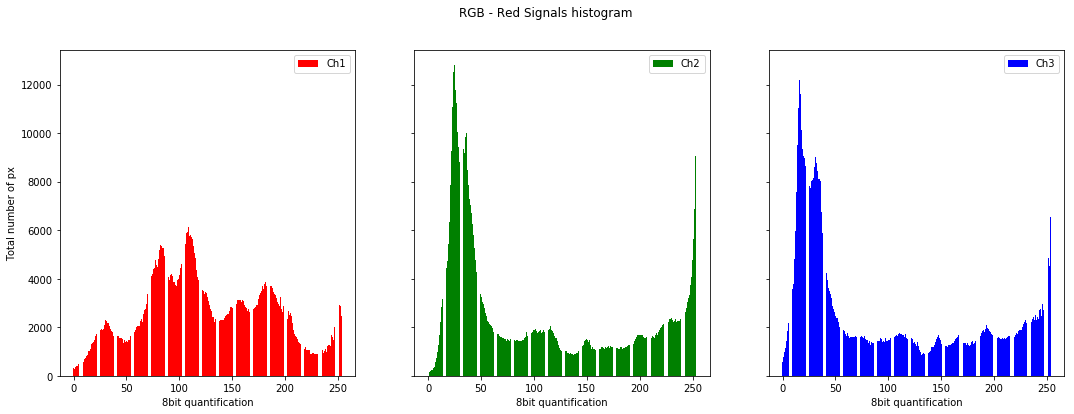

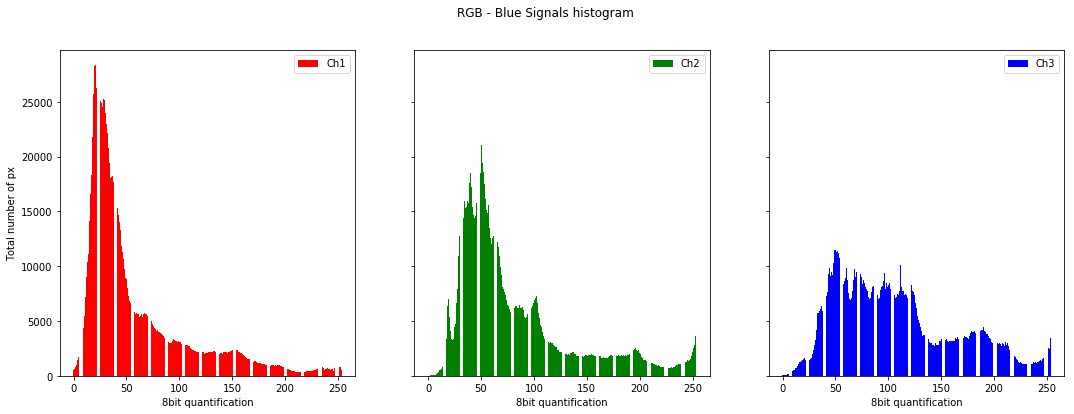

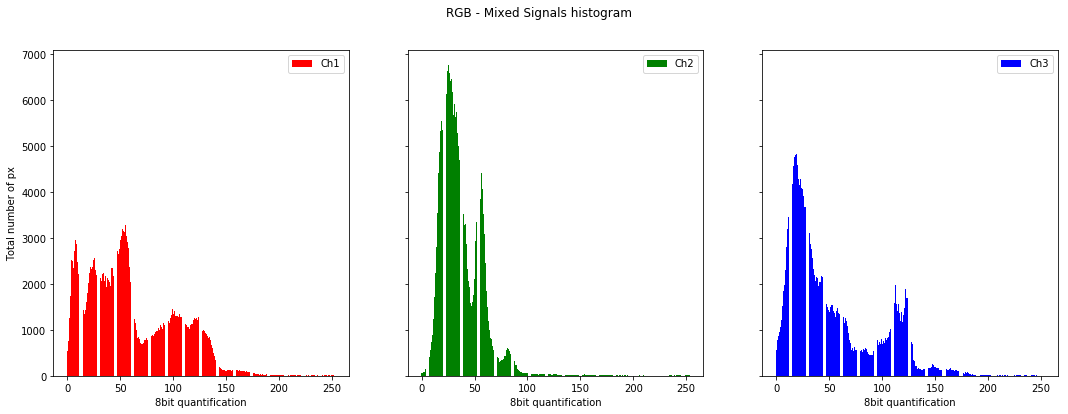

In [18]:
plot_histogram(r_hist_red, g_hist_red, b_hist_red, rgb0, rgbf, 'RGB - Red Signals')
plot_histogram(r_hist_blue, g_hist_blue, b_hist_blue, rgb0, rgbf, 'RGB - Blue Signals')
plot_histogram(r_hist_mix, g_hist_mix, b_hist_mix, rgb0, rgbf, 'RGB - Mixed Signals')

Plot normalized RGB histograms:

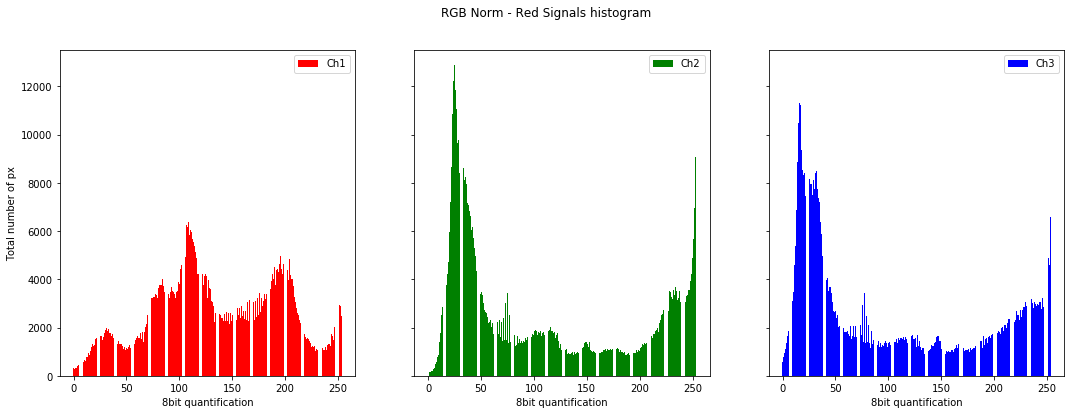

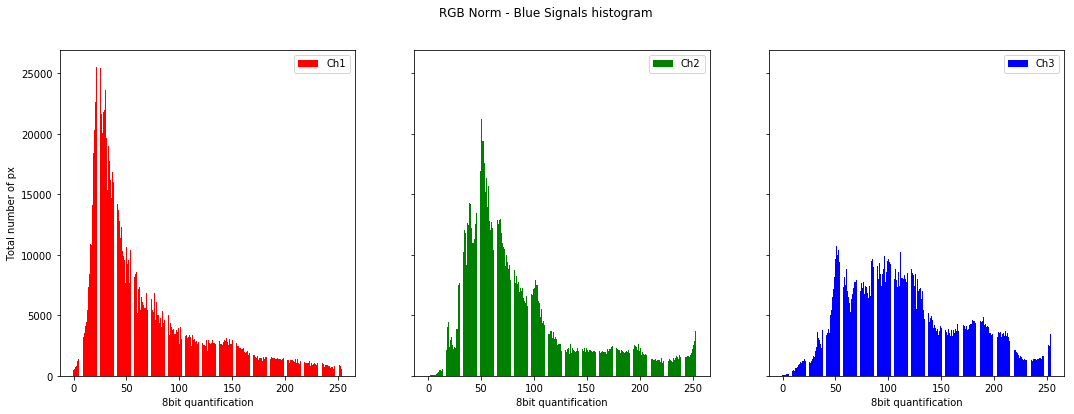

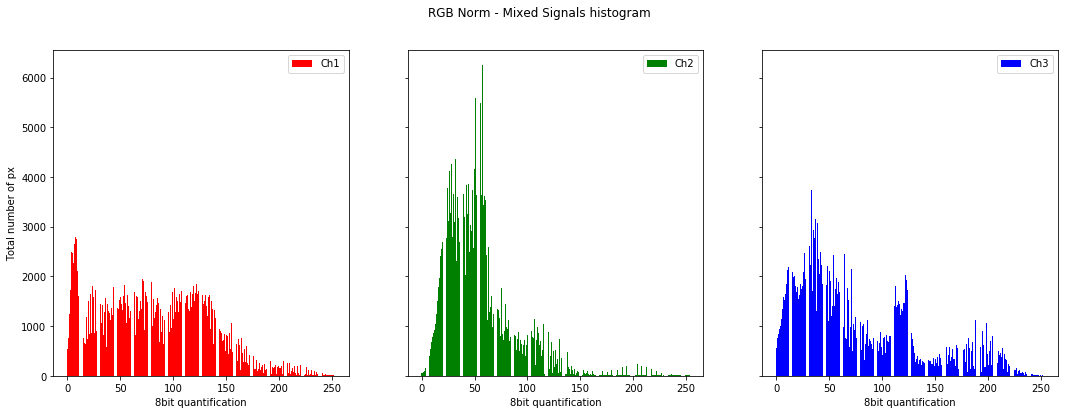

In [19]:
plot_histogram(r_hist_norm_red, g_hist_norm_red, b_hist_norm_red, rgb0, rgbf, 'RGB Norm - Red Signals')
plot_histogram(r_hist_norm_blue, g_hist_norm_blue, b_hist_norm_blue, rgb0, rgbf, 'RGB Norm - Blue Signals')
plot_histogram(r_hist_norm_mix, g_hist_norm_mix, b_hist_norm_mix, rgb0, rgbf, 'RGB Norm - Mixed Signals')

Plot HSV histograms:

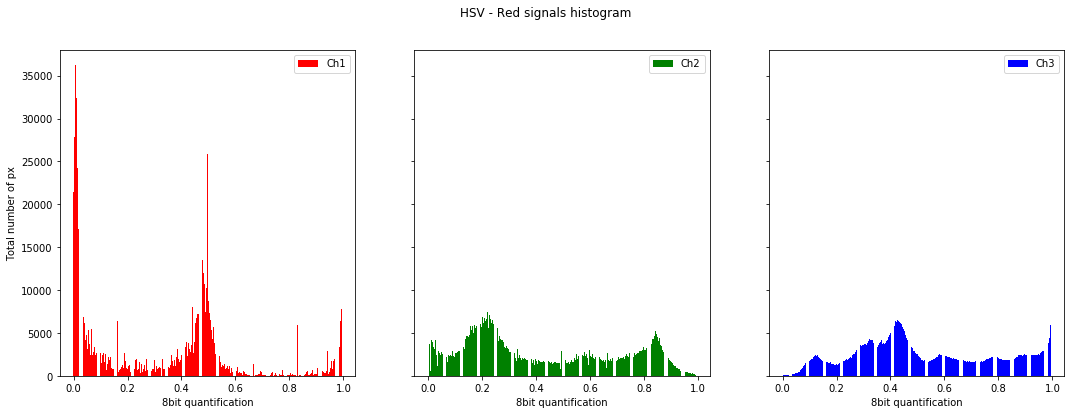

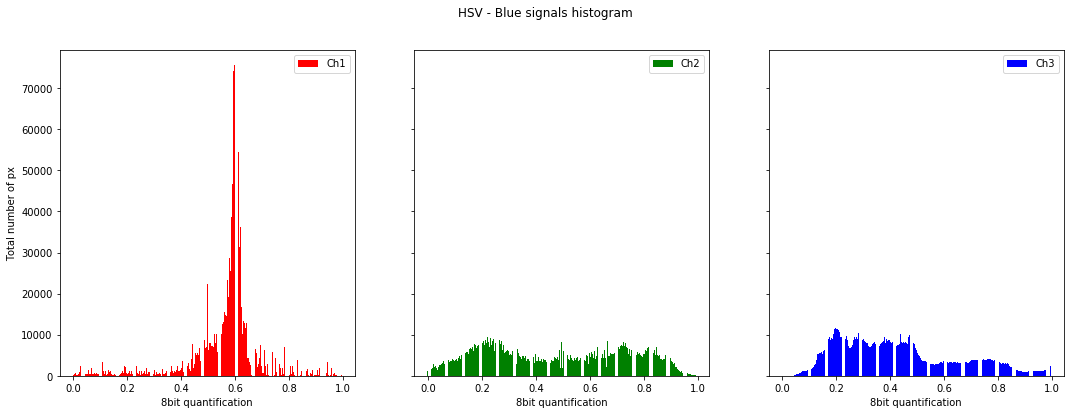

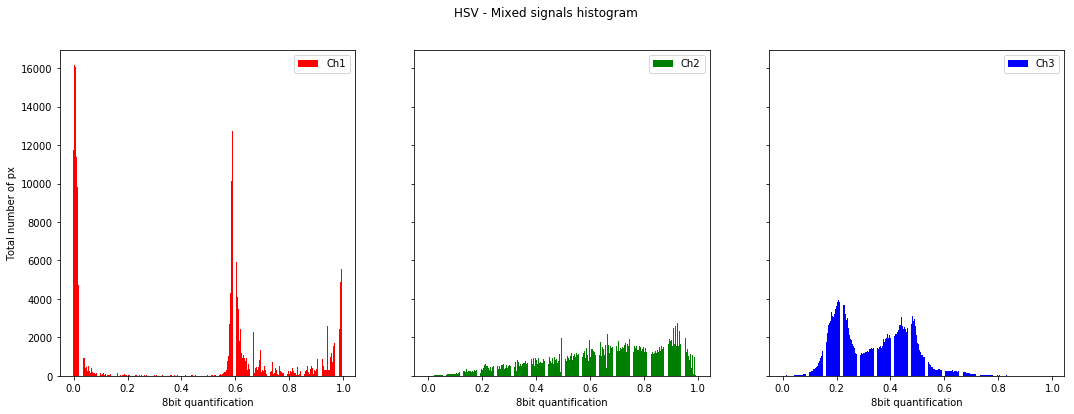

In [20]:
plot_histogram(h_hist_red, s_hist_red, v_hist_red, hsv0, hsvf, 'HSV - Red signals')
plot_histogram(h_hist_blue, s_hist_blue, v_hist_blue, hsv0, hsvf, 'HSV - Blue signals')
plot_histogram(h_hist_mix, s_hist_mix, v_hist_mix, hsv0, hsvf, 'HSV - Mixed signals')

Plot yCbCr histograms:

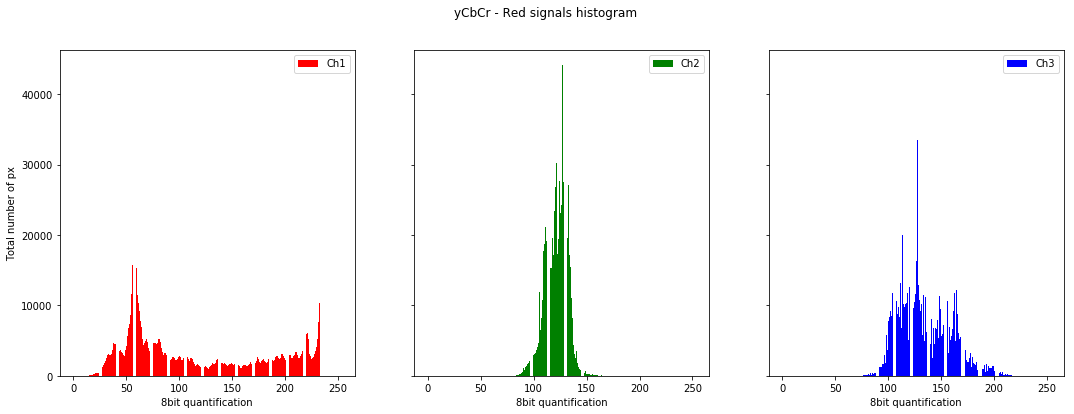

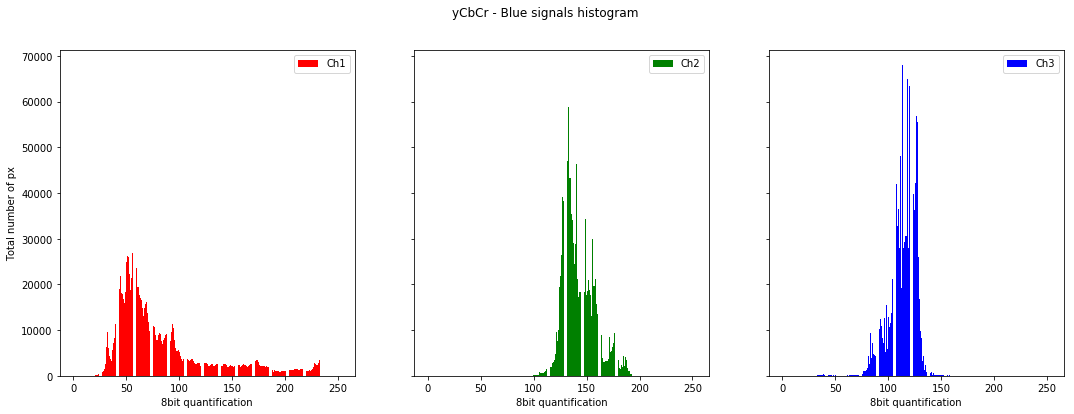

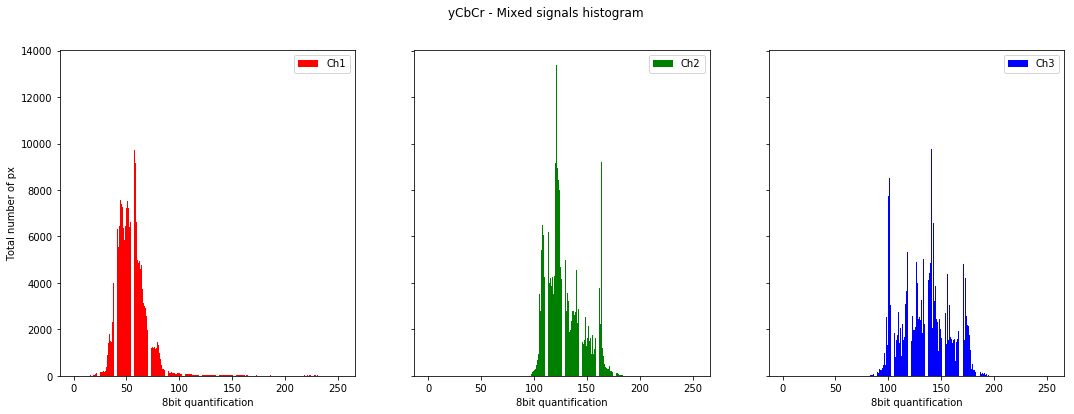

In [21]:
plot_histogram(y_hist_red, cb_hist_red, cr_hist_red, ycbcr0, ycbcrf, 'yCbCr - Red signals')
plot_histogram(y_hist_blue, cb_hist_blue, cr_hist_blue, ycbcr0, ycbcrf, 'yCbCr - Blue signals')
plot_histogram(y_hist_mix, cb_hist_mix, cr_hist_mix, ycbcr0, ycbcrf, 'yCbCr - Mixed signals')

Plot XYZ histograms:

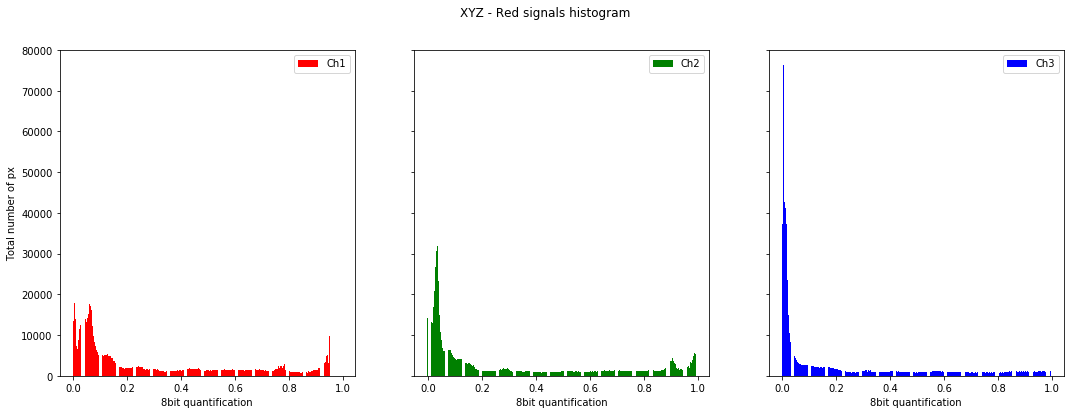

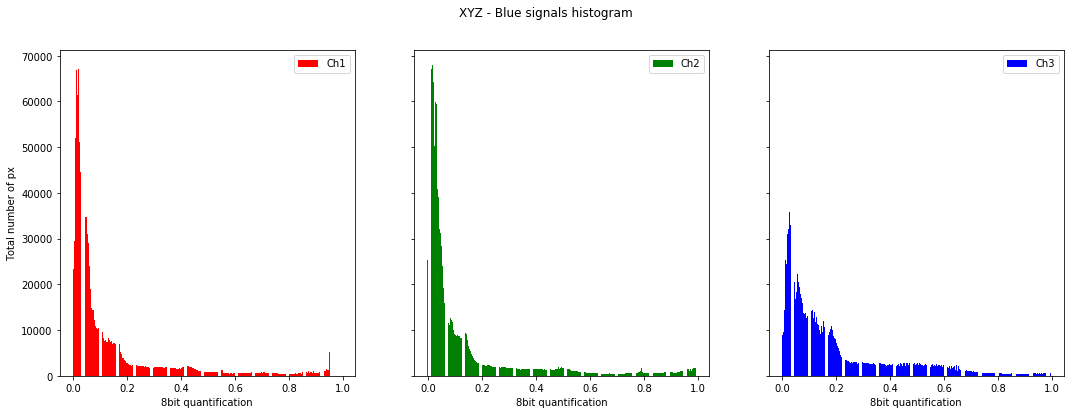

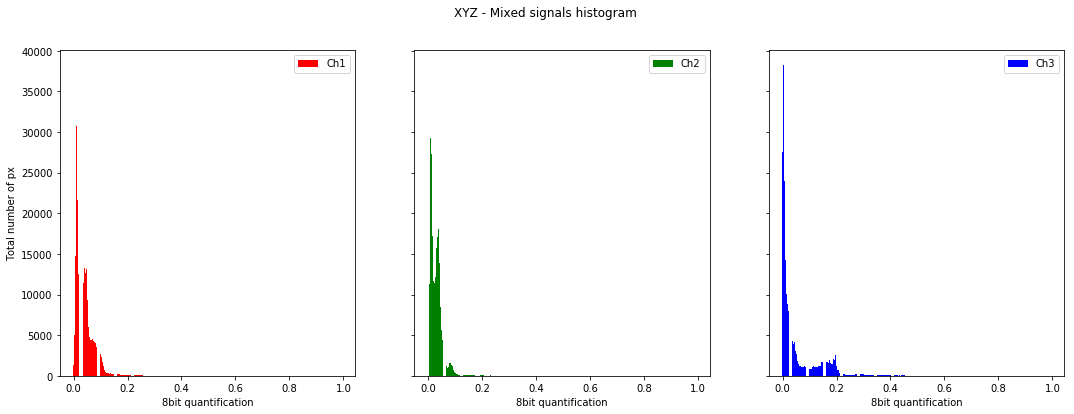

In [22]:
plot_histogram(xx_hist_red, yy_hist_red, zz_hist_red, xyz0, xyzf, 'XYZ - Red signals')
plot_histogram(xx_hist_blue, yy_hist_blue, zz_hist_blue, xyz0, xyzf, 'XYZ - Blue signals')
plot_histogram(xx_hist_mix, yy_hist_mix, zz_hist_mix, xyz0, xyzf, 'XYZ - Mixed signals')



## Conclusions: 

1. HSV & yCbCr are better than RGB or XYZ for color segmentation.

2. Selected thresholds: 
    - RGB: Red: r > 0.03; 0.46 < r < 0.51; 0.98 < r
    - RGB: Blue: 0.59 < b < 0.62
    - yCbCr: Cb = 0.4 < cb < 0.65
    - yCbCr: Cr = 0.38 < Cr < 0.7
    
3. We only study the colors of the signals, so we expect to have False Positives of the same colors in the background